# FakeFinder: Upgrading the Expedition with Transfer Learning



<a name='0'></a>
## Imports

In [1]:
import numpy
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as tv_models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [2]:
import helper_utils
import unittests

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {DEVICE}")

Using Device: cuda


<a name='1'></a>
## 1 - Preparing for the Next Expedition: A Quick Reconnaissance

 the data layout:

```
./AIvsReal_sampled/
└───train/
|   ├───fake/
|   │   ├───0046.jpg
|   │   └───...
|   └───real/
|       ├───0046.jpg
|       └───...
└───test/
    ├───fake/
    │   ├───0046.jpg
    │   └───...
    └───real/
        ├───0046.jpg
        └───...
```



In [4]:
# Load the dataset path
dataset_path = "./AIvsReal_sampled"  

# Analyzes the dataset splits at the given path and prints a count of images for each class.
helper_utils.dataset_images_per_class(dataset_path)

Analyzing dataset at: ./AIvsReal_sampled

— Train —
Fake: 2500 images
Real: 2500 images

— Test —
Fake: 500 images
Real: 500 images



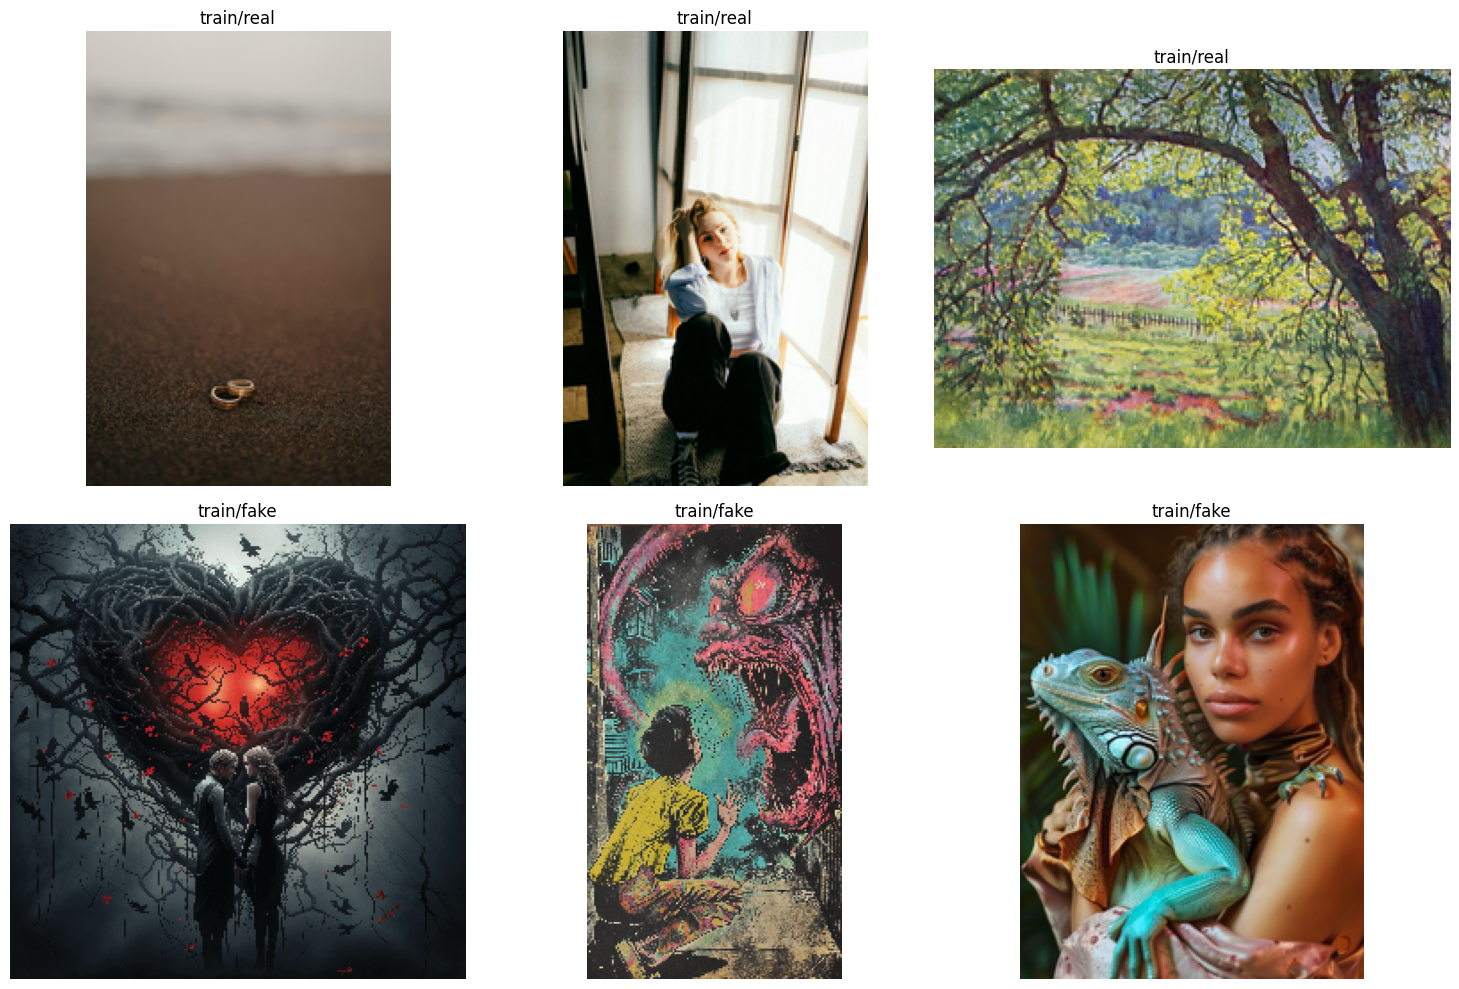

In [5]:
# Randomly select and display a grid of sample images from the 'train' folder.
helper_utils.display_train_images(dataset_path)

<a name='1-1'></a>
### 1.1 - Scouting the Archives: Loading Data with ImageFolder



In [ ]:

def create_dataset_splits(data_path):
    """
    Creates training and validation datasets from a directory structure using ImageFolder.

    Args:
        data_path (str): The root path to the dataset directory, which should
                         contain 'train' and 'validation/test' subdirectories.

    Returns:
        tuple: A tuple containing the train_dataset and validation_dataset
               (train_dataset, validation_dataset).
    """

    # Construct the full path to the training data directory.
    train_path = data_path + "/train"
    # Construct the full path to the validation data directory.
    val_path = data_path + "/test"

    
    
    # Create the train dataset using ImageFolder
    train_dataset = ImageFolder(
        root=train_path
    ) 

    # Create the validation dataset using ImageFolder
    val_dataset = ImageFolder(
        root=val_path
    ) 

    

    return train_dataset, val_dataset

In [7]:
# Verify that the function loads the datasets
temp_train, temp_val = create_dataset_splits(dataset_path)

print("--- Training Dataset ---")
print(temp_train)
print("\n--- Validation Dataset ---")
print(temp_val)

--- Training Dataset ---
Dataset ImageFolder
    Number of datapoints: 5000
    Root location: ./AIvsReal_sampled/train

--- Validation Dataset ---
Dataset ImageFolder
    Number of datapoints: 1000
    Root location: ./AIvsReal_sampled/test


<a name='1-2'></a>
### 1.2 - Specialized Augmentations: Protocols for Training and Validation



In [9]:
# Define the standard mean values for the ImageNet dataset
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])

# Define the standard standard deviation values for the ImageNet dataset
imagenet_std = torch.tensor([0.229, 0.224, 0.225])

In [ ]:


def define_transformations(mean=imagenet_mean, std=imagenet_std):
    """
    Defines separate series of image transformations for training and validation datasets.

    Args:
        mean (list or tuple): The mean values (for each channel, e.g., RGB) calculated from ImageNet.
        std (list or tuple): The standard deviation values (for each channel) calculated from ImageNet.

    Returns:
        tuple: A tuple containing two `torchvision.transforms.Compose` objects:
               - The first for training transformations.
               - The second for validation transformations.
    """

    

    # Create a Compose object to chain multiple transformations together for the training set
    from torchvision import transforms

    train_transform = transforms.Compose([
        # Randomly resize and crop the input image to 224x224 pixels
        transforms.RandomResizedCrop((224, 224)),

        # Apply a random horizontal flip to the image for data augmentation
        transforms.RandomHorizontalFlip(),

        # Randomly change the brightness and contrast of the image
        transforms.ColorJitter(brightness=0.2, contrast=0.2),

        # Convert the PIL Image to a PyTorch Tensor
        transforms.ToTensor(),

        # Normalize the tensor image with the provided 'mean' and 'std'
        transforms.Normalize(mean=mean, std=std),
    ])

    # Create a Compose object to chain multiple transformations together for the validation set
    val_transform = transforms.Compose([
        # Resize the input image to 224x224 pixels
        transforms.Resize((224, 224)),

        # Convert the PIL Image to a PyTorch Tensor
        transforms.ToTensor(),

        # Normalize the tensor image with the provided 'mean' and 'std'
        transforms.Normalize(mean=mean, std=std),
    ])

    

    return train_transform, val_transform

In [11]:
# Create the composed transformations
combined_transformations = define_transformations()

# Print the composed transformations to verify the sequence of operations
print("Augmented Training Transformations:\n")
print(combined_transformations[0])
print("\nValidation Transformations:\n")
print(combined_transformations[1])

Augmented Training Transformations:

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=None, hue=None)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

Validation Transformations:

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


<a name='1-3'></a>
### 1.3 - Preparing the Data Launchpad: Applying Transformations and Batching Data



In [ ]:


def create_data_loaders(trainset, valset, batch_size):
    """
    Creates DataLoader instances for training and validation datasets with respective transformations.

    Args:
        trainset (torch.utils.data.Dataset): The training dataset.
        valset (torch.utils.data.Dataset): The validation dataset.
        batch_size (int): The number of samples to load in each batch.

    Returns:
        tuple: A tuple containing:
            - train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
            - val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
            - trainset (torch.utils.data.Dataset): The original training dataset with transformations now applied.
            - valset (torch.utils.data.Dataset): The original validation dataset with transformations now applied.
    """
    
    
    
    from torch.utils.data import DataLoader

    # Define separate transformations for the training and validation datasets
    train_transform, val_transform = define_transformations()
    
    # Apply the transformations to their respective datasets
    trainset.transform = train_transform
    valset.transform = val_transform
    
    # Create DataLoader for the training dataset
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    
    # Create DataLoader for the validation dataset
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False)
    
    
    
    return train_loader, val_loader, trainset, valset

In [14]:
dataloaders = create_data_loaders(temp_train, temp_val, batch_size=16)

print("--- Train Loader ---")
helper_utils.display_data_loader_contents(dataloaders[0])
print("\n--- Val Loader ---")
helper_utils.display_data_loader_contents(dataloaders[1])

--- Train Loader ---
Length: 313
--- Batch 1 ---
Data shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])

--- Val Loader ---
Length: 63
--- Batch 1 ---
Data shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


<a name='2'></a>
## 2 - Advanced Expedition: Leveraging Pre-trained Model Wisdom



The benefits of this approach are substantial:

* **Accelerated Discovery**:  get a significant head start, as the model has already learned a rich set of features.
* **Superior Performance**: Pre-trained models often achieve higher accuracy, especially when the dataset is small.

<a name='2-1'></a>
### 2.1 - Selecting  Champion: Introducing MobileNetV3-Large


**Why MobileNetV3-Large?**

It’s an excellent choice for a task like identifying AI-generated images due to its:

* **High Efficiency**: It offers an outstanding trade-off between accuracy and resource usage, making it highly suitable for performance on resource-constrained environments.
* **Strong Classification Accuracy**: Despite its focus on efficiency, MobileNetV3-Large delivers robust performance, incorporating advanced design elements optimized through Neural Architecture Search (NAS).
* **Effective Feature Extraction**: Having been pre-trained on the massive ImageNet dataset, the model has already learned a rich hierarchy of visual features, a strong foundation you can adapt to distinguish between real and fake images.



In [ ]:


def load_mobilenetv3_model(weights_path):
    """
    Loads a pre-trained MobileNetV3-Large model from torchvision.

    Args:
        weights_path (str): The file path to the saved .pth model weights.
        
    Returns:
        torch.nn.Module: A pre-trained MobileNetV3-Large model.
    """
  

    import torch
    import torchvision.models as tv_models

    # Load the MobileNetV3-Large architecture with no pre-trained weights
    model = tv_models.mobilenet_v3_large(weights=None)

    # Load the state dictionary (weights) from the local file
    state_dict = torch.load(weights_path, map_location=torch.device('cpu'))

    
    
    model.load_state_dict(state_dict)

    return model

In [17]:
# Load the pre-trained MobileNetV3-Large model using weights from the local file.
local_weights = "./mobilenet_weights/mobilenet_v3_large-8738ca79.pth"
test_model = load_mobilenetv3_model(local_weights)

# Print the last layer of the classifier of the loaded model
print(test_model.classifier[-1])

Linear(in_features=1280, out_features=1000, bias=True)


<a name='2-2'></a>
### 2.2 - Tailoring Your Champion: Adapting MobileNetV3 for Fake Detection


* **Freezing the Core Layers**: The early layers of the model, which are responsible for extracting general visual patterns like edges, textures, and shapes, contain invaluable knowledge. By **freezing** these layers,  prevent their weights from being updated during training. This preserves the model's powerful foundation, significantly reduces the number of trainable parameters, and accelerates training.

* **Replacing the Classifier Head**: The original model's final classifier is configured for 1,000 classes and is not suitable for  two-class task. replace it with a new, custom-built classifier. This new layer will take the high-level features from the frozen core and output a prediction for  two target classes, preparing  model to become a specialized FakeFinder.



In [ ]:


def update_model_last_layer(model, num_classes):
    """
    Freezes the feature layers of a pre-trained model and replaces its final
    classification layer with a new one adapted to the specified number of classes.

    Args:
        model (torch.nn.Module): The pre-trained model to be modified.
        num_classes (int): The number of output classes for the new classification layer.

    Returns:
        torch.nn.Module: The modified model with frozen feature layers and a new
                         classification layer.
    """
    
    import torch.nn as nn

    # Freeze feature extraction layers
    for feature_parameter in model.features.parameters():
        feature_parameter.requires_grad = False

    # Get the existing classifier's last layer
    last_classifier_layer = model.classifier[-1]

    # Retrieve number of input features
    num_features = last_classifier_layer.in_features

    # Create a new linear layer for the new number of classes
    new_classifier = nn.Linear(in_features=num_features, out_features=num_classes)

    # Replace the last layer with the new classifier
    model.classifier[-1] = new_classifier
    

    return model

In [20]:
# Modify the last layer of the MobileNetV3-Large model
test_model = update_model_last_layer(test_model, num_classes=5)

# Print the last layer of the classifier of the modified model
print(test_model.classifier[-1])

Linear(in_features=1280, out_features=5, bias=True)


<a name='3'></a>
## 3 - Final Expedition: Training and Evaluating  Adapted Champion


<a name='3-1'></a>
### 3.1 - Setting the Launchpad: Preparing DataLoaders and the Adapted Model




In [22]:
# Initialize the training and validation datasets
train_dataset, val_dataset = create_dataset_splits(dataset_path)

# Initialize the dataloaders for training and validation
train_loader, val_loader, _, __ = create_data_loaders(train_dataset, val_dataset, batch_size=32)

In [23]:
# Load the pre-trained MobileNetV3-Large model and modify its last layer
local_weights = "./mobilenet_weights/mobilenet_v3_large-8738ca79.pth"
mobilenet_model = load_mobilenetv3_model(local_weights)
mobilenet_model = update_model_last_layer(mobilenet_model, num_classes=2)

<a name='3-2'></a>
### 3.2 - Training the Adapted Model



In [24]:
# Define the loss function to compute the difference between the model's output and the true labels
loss_fcn = nn.CrossEntropyLoss()

# Define the optimizer to update the model's weights during training
optimizer = optim.Adam(filter(lambda p: p.requires_grad, 
                             mobilenet_model.parameters()), 
                       lr=0.001)

* Define the number of epochs for training.


In [25]:
# EDITABLE CELL:

# Set the number of epochs
num_epochs = 1

In [26]:
# Train the model
trained_model = helper_utils.training_loop(
    mobilenet_model, 
    train_loader, 
    val_loader,
    loss_fcn,
    optimizer,
    DEVICE, 
    num_epochs
)

Epoch 1/1 Training:   0%|          | 0/157 [00:00<?, ?batch/s]

Epoch 1/1 Validating:   0%|          | 0/32 [00:00<?, ?batch/s]

Val Loss (Avg): 0.3428, Val Accuracy: 85.30%

New best model saved to ./best_model_saved/best_model.pth with Val Accuracy: 85.30%


Training ended. Best trained model returned.
Best Val Accuracy: 85.30%
Best Val Precision: 0.8531
Best Val Recall: 0.8530



<a name='3-3'></a>
### 3.3 - Performance Review: Visualizing Predictions



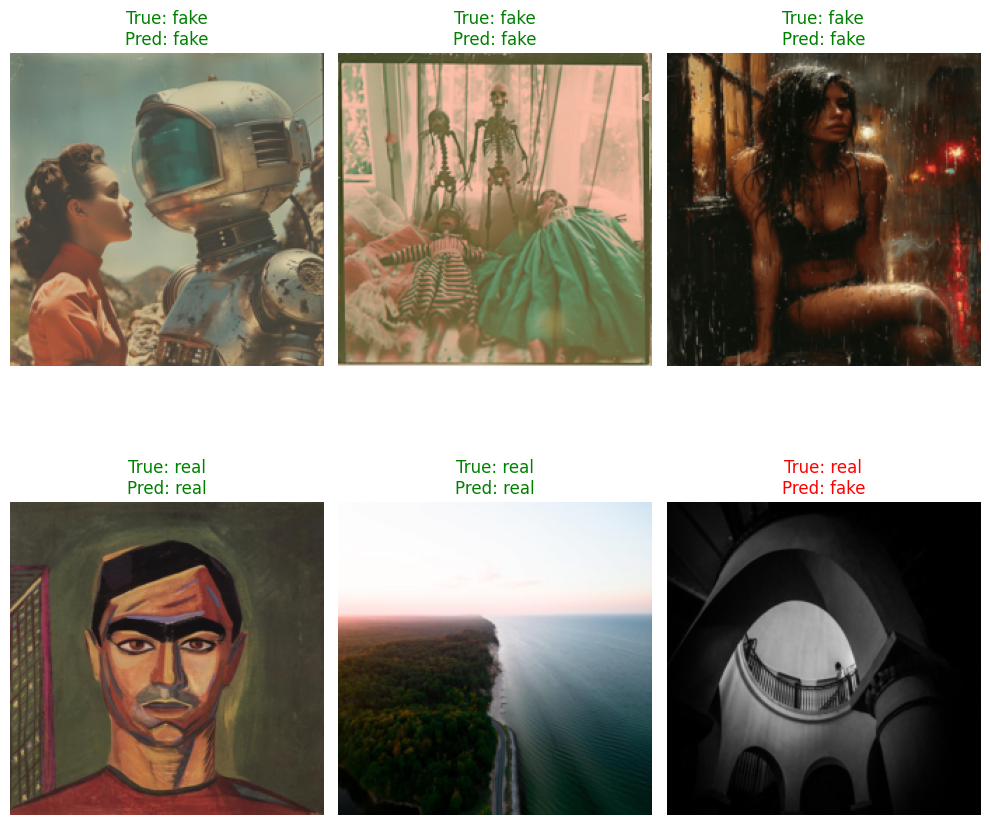

In [27]:
# Get the list of class names ('fake', 'real') from the validation dataset.
class_names = val_dataset.classes

# Visualise predictions made by the trained model
helper_utils.visualize_predictions(trained_model, val_loader, DEVICE, class_names)

#### Test  FakeFinder on a New Image



In [28]:
helper_utils.upload_jpg_widget()

FileUpload(value=(), accept='.jpg', description='Upload JPG (Max 5MB)')

Output()

* Set the path to  image (as displayed above).

Alternatively,  these images that are already present in the workspace:
> * `image_path = './images/fake/birds_sheep_dog.jpg'`
> * `image_path = './images/fake/car_bus_tram.jpg'`
> * `image_path = './images/fake/person_and_bicycle.jpg'`
> * `image_path = './images/real/eiffel_tower.jpg'`
> * `image_path = './images/real/minar.jpg'`
> * `image_path = './images/real/statue_liberty.jpg'`




In [ ]:
# EDITABLE CELL:

image_path = './images/fake/birds_sheep_dog.jpg' ### Add  image path here

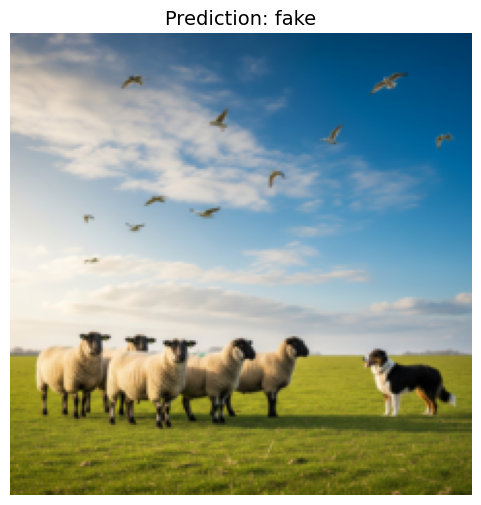

In [30]:
# Display a prediction for the single uploaded image.
helper_utils.make_predictions(trained_model, image_path, DEVICE, class_names)